# Skrinning Stuff

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import solarpy
import datetime

currentDir = os.getcwd()
sys.path.append(os.path.join(currentDir, '../code/'))
import geomUtils as geom
import IceSheet

In [2]:
geom.charLength('hex', [2.])

1.7320508075688774

In [3]:
diamsCrystal = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.])  # m
gapMelt = 1.e-4  # m

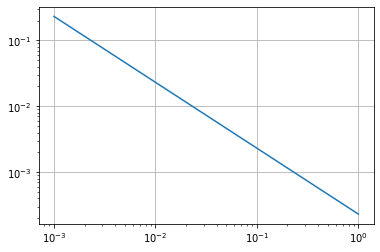

In [4]:
porosities = [(geom.periphery('hex', [x])*gapMelt/2)/(geom.area('hex', [x])) for x in diamsCrystal]
plt.loglog(diamsCrystal, porosities)
plt.grid()

### Simulate a Day or Two

In [5]:
# __init__
dateTimeStart = datetime.datetime(2021, 3, 21, 0, 0)
myIce = IceSheet.IceSheet(dateTime=dateTimeStart, sheet='blackIce', thickness=100.0, crystalSize=100.0, lat=55.71, alt=10)
myWater = IceSheet.IceSheet(dateTime=dateTimeStart, sheet='freshWater', thickness=1000.0, crystalSize=100.0, lat=55.71, alt=10)
myWater.setTransmittance(myIce)

When: 2021-03-21 00:00:00
Where: lat = 55.71°, alt = 10 m
What: blackIce
When: 2021-03-21 00:00:00
Where: lat = 55.71°, alt = 10 m
What: freshWater


In [6]:
# setupModel
spatialNodeCount = 101
timeStep = 2*60  # s
aEnv=[0.05, 0.9, 0.05]
TEnv=[-2.0, -20.0, -270.]
aEnvW=[1.]
TEnvW=[0.]

# get started
A, B, b, UInit = myIce.setupModel(IC=[-0.92, 0.], aEnv=aEnv, TEnv=TEnv, fluidVelocity=0.02, zNodes=spatialNodeCount, tStep=timeStep, isVerbose=True)
AW, BW, bW, UInitW = myWater.setupModel(IC=[0., 4.], aEnv=aEnv, TEnv=TEnv, fluidVelocity=0.12, zNodes=spatialNodeCount, tStep=timeStep, isVerbose=True)

thermal diffusivity a = 1.14e-06 m2/s
spatial stepsize dz = 1.00 mm
temporal stepsize dt = 120.00 s
timescale tScale = 8769.8 s
sigma = 68.41698573954736
irradiance S0 = 0 W/m2
thermal diffusivity a = 1.33e-07 m2/s
spatial stepsize dz = 10.00 mm
temporal stepsize dt = 120.00 s
timescale tScale = 7530636.4 s
sigma = 0.07967454088257198
8 [0.97698847 1.12629004 1.26697781 1.39764537 1.51729804 1.62542016
 1.72196992 1.80731496 1.88213309 1.94730316 2.00380555 2.0526425
 2.09478171 2.13112103 2.16247    2.18954367 2.21296418 2.23326711
 2.25091006 2.26628206 2.27971281 2.29148127 2.3018233  2.31093844
 2.31899561 2.32613806 2.33248745 2.33814738 2.34320623 2.34773959
 2.3518123  2.3554801  2.35879102 2.36178663 2.36450289 2.36697111
 2.36921851 2.3712689  2.37314311 2.37485943 2.37643395 2.37788086
 2.37921268 2.38044054 2.38157428 2.38262268 2.38359355 2.38449388
 2.3853299  2.38610723 2.38683089 2.3875054  2.38813484 2.38872289
 2.38927289 2.38978784 2.39027049 2.3907233  2.39114855 2.3

In [7]:
# simulate
totalTime = 48*3600  # s
timeStepCount = totalTime//timeStep
timeStepCount

1440

In [8]:
dateTimes, S0s, USoln, epsSoln, dEpsSoln = myIce.simulate(UInit, aEnv, TEnv, timeStepCount)
dateTimes, S0sW, USolnW, dummy, dummy2 = myWater.simulate(UInitW, aEnvW, TEnvW, timeStepCount)

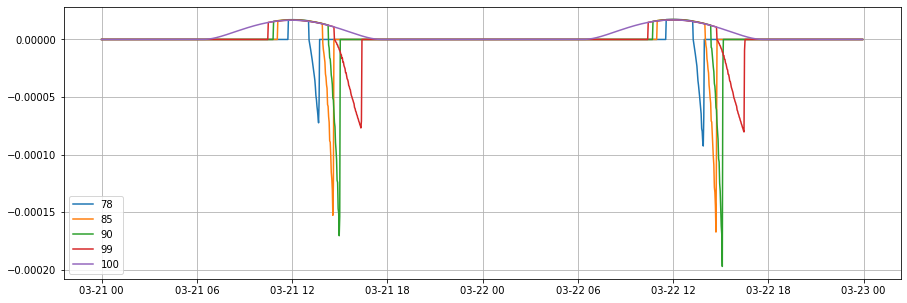

In [9]:
idx = [78, 85, 90, 99, 100]
itx = [0, -1]
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for i in range(len(idx)):
    ax.plot(dateTimes[itx[0]:itx[1]], dEpsSoln[itx[0]:itx[1], idx[i]], label=str(idx[i]))
ax.grid()
ax.legend()

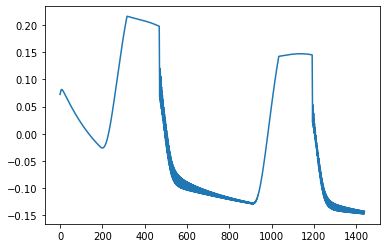

In [10]:
botMeltRates = myIce.bottomMeltRates(USoln, USolnW, myWater)
plt.plot(botMeltRates*3600000)

In [11]:
idxSunUp = []
idxSunDn = []
for i in range(len(dateTimes)):
    if S0s[i] > 0 and S0s[i-1] == 0:
        idxSunUp.append(i)
    if S0s[i] == 0 and S0s[i-1] > 0:
        idxSunDn.append(i-1)
print(idxSunUp, idxSunDn)

[181, 900] [539, 1260]


In [12]:
dEpsSoln.shape

(1440, 101)

In [13]:
np.cumsum(dEpsSoln, axis=0).shape

(1440, 101)

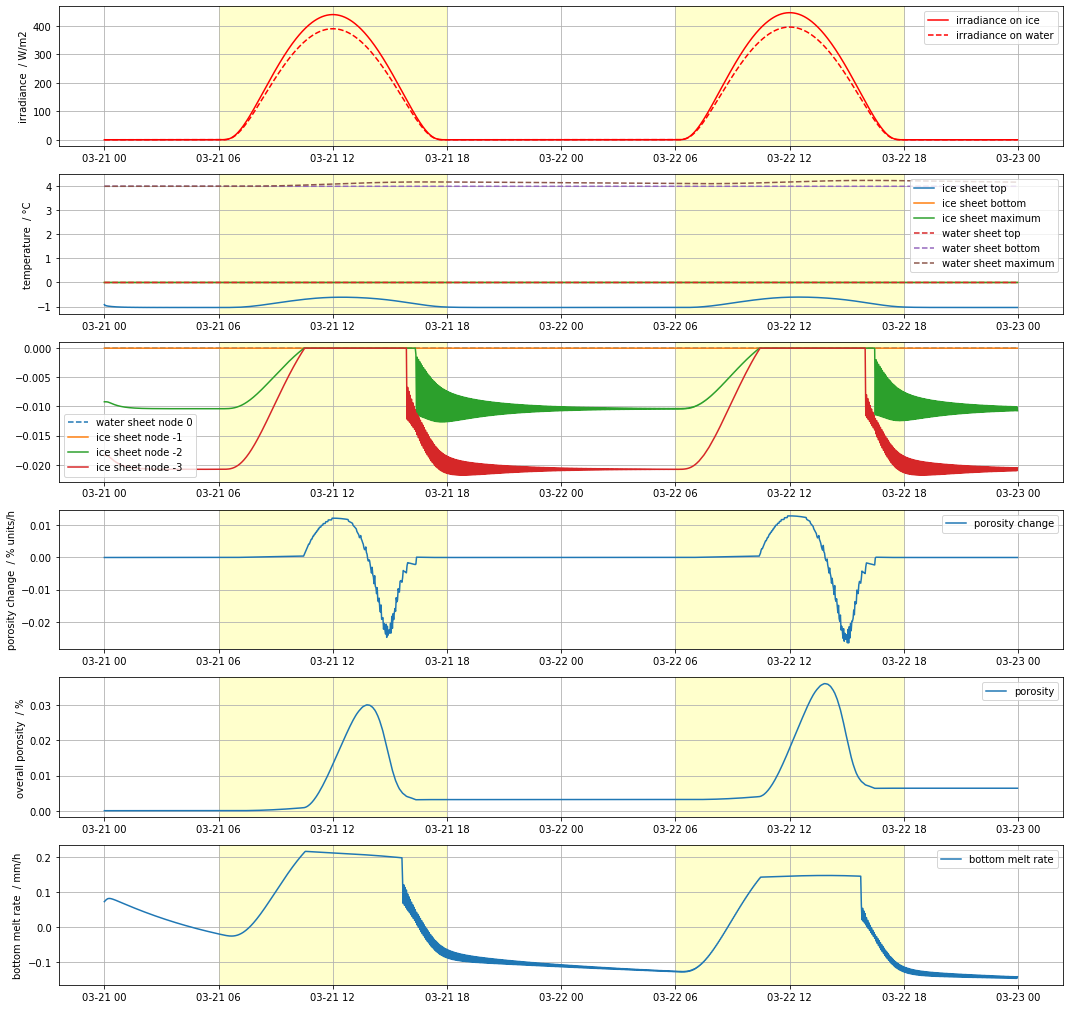

In [14]:
epssz = np.cumsum(dEpsSoln, axis=0)
UMaxs = []
epss = []
dEpss = []
UMaxsW = []
for j in range(len(USoln)):
    UMaxs.append(np.max(USoln[j, :]))
    epss.append(epsSoln[j].sum()*myIce._dx)
#     epss.append(epssz[j].sum()*myIce._dx)
    dEpss.append(dEpsSoln[j].sum()*myIce._dx)
    UMaxsW.append(np.max(USolnW[j, :]))
epss = np.array(epss)
dEpss = np.array(dEpss)/(timeStep/3600)  # per hour

nPlot = 6
fig, axs = plt.subplots(nPlot, 1, figsize=(18, nPlot*3))
i = 0
axs[i].plot(dateTimes, S0s, color='red', label='irradiance on ice')
axs[i].plot(dateTimes, S0sW, '--', color='red', label='irradiance on water')
axs[i].set_ylabel('irradiance  / W/m2')
i = i + 1
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, 0]), label='ice sheet top')
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, -1]), label='ice sheet bottom')
axs[i].plot(dateTimes, myIce.makeUOneD(np.array(UMaxs)), label='ice sheet maximum')
axs[i].plot(dateTimes, myWater.makeUOneD(USolnW[:, 0]), '--', label='water sheet top')
axs[i].plot(dateTimes, myWater.makeUOneD(USolnW[:, -1]), '--', label='water sheet bottom')
axs[i].plot(dateTimes, myWater.makeUOneD(np.array(UMaxsW)), '--', label='water sheet maximum')
axs[i].set_ylabel('temperature  / °C')
i = i + 1
# axs[i].plot(dateTimes, myWater.makeUOneD(USolnW[:, 1]), '--', label='water sheet node 1')
axs[i].plot(dateTimes, myWater.makeUOneD(USolnW[:, 0]), '--', label='water sheet node 0')
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, -1]), label='ice sheet node -1')
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, -2]), label='ice sheet node -2')
axs[i].plot(dateTimes, myIce.makeUOneD(USoln[:, -3]), label='ice sheet node -3')
i = i + 1
axs[i].plot(dateTimes, dEpss*100, label='porosity change')
axs[i].set_ylabel('porosity change  / % units/h')
i = i + 1
axs[i].plot(dateTimes, epss*100, label='porosity')
axs[i].set_ylabel('overall porosity  / %')
i = i + 1
axs[i].plot(dateTimes, botMeltRates*1000*3600, label='bottom melt rate')
axs[i].set_ylabel('bottom melt rate  / mm/h')
for i in range(nPlot):
    for j in range(len(idxSunUp)):
        axs[i].axvspan(dateTimes[idxSunUp[j]], dateTimes[idxSunDn[j]], color='yellow', alpha=0.2)
    axs[i].grid()
    axs[i].legend()    

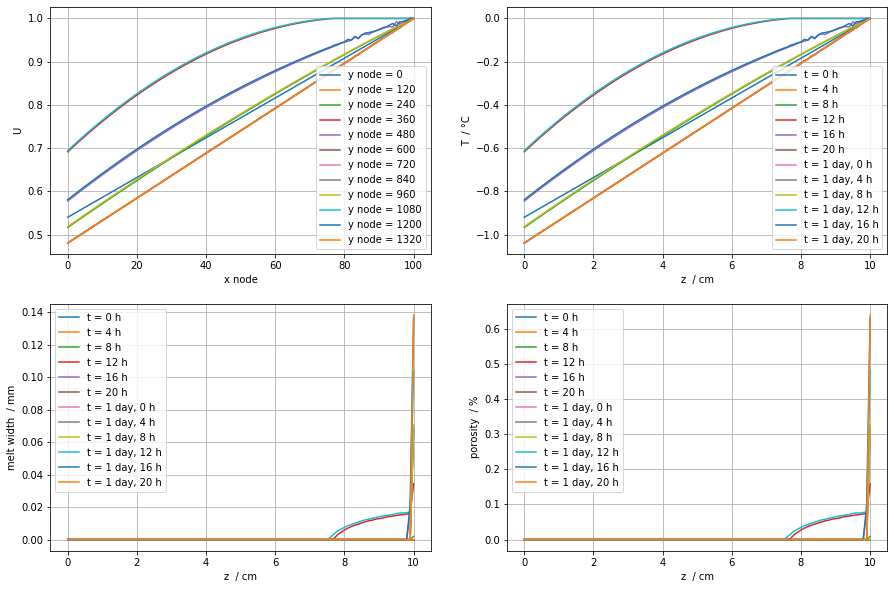

In [15]:
TSoln = myIce.makeUOneD(USoln)

z = np.linspace(0, spatialNodeCount, spatialNodeCount)*myIce._h/spatialNodeCount*100  # cm

plotInterval = 4  # h
idxInterval = (plotInterval*3600)//timeStep

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for j in list(range(len(USoln)))[::idxInterval]:
    timeLabel = 't = '+'{} h'.format(str(dateTimes[j]-dateTimes[0])[:-6])
    i, k = 0, 0
    axs[i, k].plot(range(spatialNodeCount), USoln[j, :], label='y node = '+'{}'.format(j))
    i, k = 0, 1
    axs[i, k].plot(z, TSoln[j, :], label=timeLabel)
    i, k = 1, 1
    axs[i, k].plot(z, epsSoln[j]*100, label=timeLabel)
    i, k = 1, 0
    axs[i, k].plot(z, epsSoln[j, :]*geom.area('hex', [myIce._crystSize])/geom.periphery('hex', [myIce._crystSize])*1000, label=timeLabel)
i, k = 0, 0
axs[i, k].set_xlabel('x node')
axs[i, k].set_ylabel('U')
i, k = 0, 1
axs[i, k].set_xlabel('z  / cm')
axs[i, k].set_ylabel('T  / °C')
i, k = 1, 1
axs[i, k].set_xlabel('z  / cm')
axs[i, k].set_ylabel('porosity  / %')
i, k = 1, 0
axs[i, k].set_xlabel('z  / cm')
axs[i, k].set_ylabel('melt width  / mm')
for i in range(2):
    for k in range(2):
        axs[i, k].legend()
        axs[i, k].grid()

No handles with labels found to put in legend.


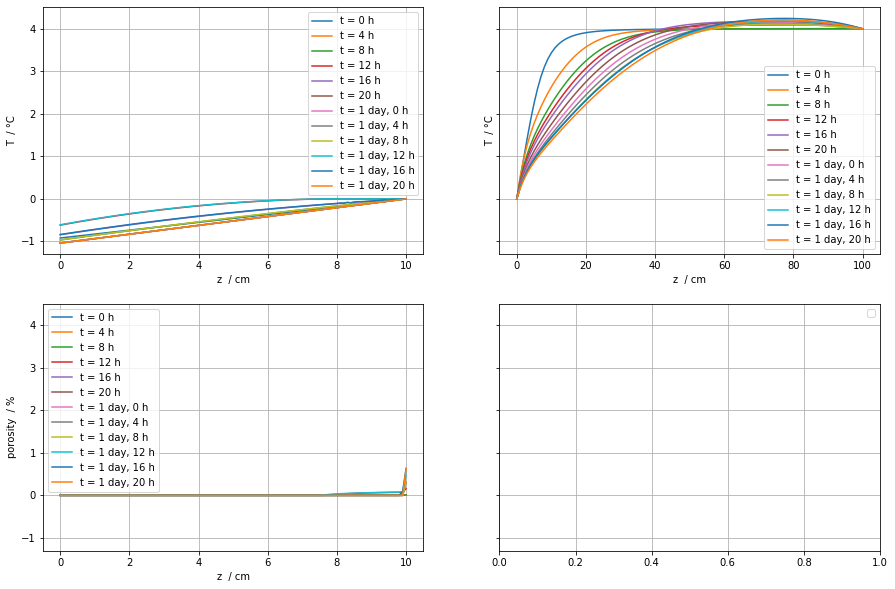

In [16]:
TSoln = myIce.makeUOneD(USoln)
TSolnW = myWater.makeUOneD(USolnW)

z = np.linspace(0, spatialNodeCount, spatialNodeCount)*myIce._h/spatialNodeCount*100  # cm
zW = np.linspace(0, spatialNodeCount, spatialNodeCount)*myWater._h/spatialNodeCount*100  # cm

plotInterval = 4  # h
idxInterval = (plotInterval*3600)//timeStep

fig, axs = plt.subplots(2, 2, sharey=True, figsize=(15, 10))
for j in list(range(len(USoln)))[::idxInterval]:
    timeLabel = 't = '+'{} h'.format(str(dateTimes[j]-dateTimes[0])[:-6])
    i, k = 0, 0
    axs[i, k].plot(z, TSoln[j, :], label=timeLabel)
    i, k = 0, 1
    axs[i, k].plot(zW, TSolnW[j, :], label=timeLabel)
    i, k = 1, 0
    axs[i, k].plot(z, epsSoln[j, :]*100, label=timeLabel)
i, k = 1, 0
axs[i, k].set_xlabel('z  / cm')
axs[i, k].set_ylabel('porosity  / %')
for i in range(2):
    axs[0, k].set_xlabel('z  / cm')
    axs[0, k].set_ylabel('T  / °C')
    for k in range(2):
        axs[i, k].legend()
        axs[i, k].grid()

In [17]:
myWater._IC[0]

0.0

0.1


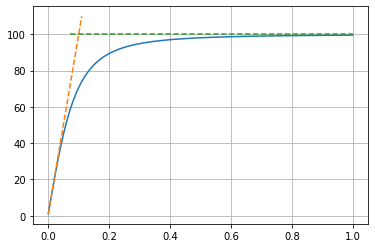

In [18]:
alpha = 10
lmbda = 1
delta = lmbda/alpha
print(delta)

lmbdaeb = 100
dlmbdadz = (lmbdaeb - lmbda)/delta

z = np.linspace(0, 10*delta, 100)
lmbdaew = lmbda + dlmbdadz*z

n = 2
lmbdae = (lmbdaew**(-n) + lmbdaeb**(-n))**(-1/n)

x = np.linspace(0, 1.1*delta, 4)
lmbdaewlim = lmbda + dlmbdadz*x

plt.plot(z, lmbdae)
plt.plot(x, lmbdaewlim, '--')
plt.plot([0.7*delta, 10*delta], [lmbdaeb, lmbdaeb], '--')
plt.grid()